# Simulation with both aware and unaware nodes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import poisson
from joblib import Parallel, delayed
import time
import sys
from scipy.optimize import minimize, Bounds, LinearConstraint, minimize_scalar

## Import reference profiles

#### Import market price (MW, Euro/MWh)

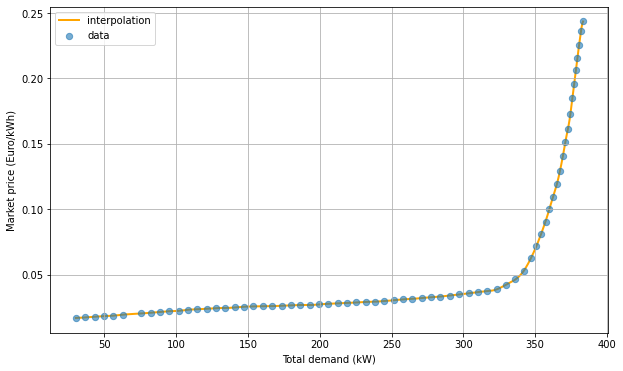

In [2]:
from scipy.interpolate import interp1d
market_price_data = np.loadtxt('data/market_price_UK.csv', delimiter=',')

# rescaling of the total demand to fit the simulation
delta = 1.7
tot_demand = market_price_data[:, 0] * 100 *delta - 210 * delta

market_price = interp1d(tot_demand, market_price_data[:, 1] / 1000, kind='cubic')

def make_market_price(b_pm,l,s,alpha,T=48):
    n_nodes = b_pm.shape[0]
    #print(n_nodes)
    #print("l",l.sum(axis=0).shape)
    #print("b",(alpha * b_pm[:, T:].sum(axis=0)).shape)
    #print("s",b_pm[:, :T].sum(axis=0).shape)
    agg_energy_demand = l.sum(axis=0) - alpha * b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0) - n_nodes*s
    return market_price( agg_energy_demand )

x = np.linspace(tot_demand[0], tot_demand[-1], 600)
plt.figure(figsize=(10,6))
plt.plot(x, market_price(x), lw=2, label='interpolation', c='orange', zorder=0)
plt.scatter(tot_demand, market_price_data[:, 1] / 1000, s=40, label='data', zorder=1, alpha=0.6)
plt.xlabel('Total demand (kW)')
plt.ylabel('Market price (Euro/kWh)')
plt.legend()
plt.grid()

#### Import photovoltaic system power profiles

,time,sunny,cloudy,rainy
0,0.0,0.000000,0.000000,0.000000
1,0.5,0.003189,0.001772,0.000213
2,1.0,0.004659,0.002588,0.000311
3,1.5,0.004659,0.002588,0.000311


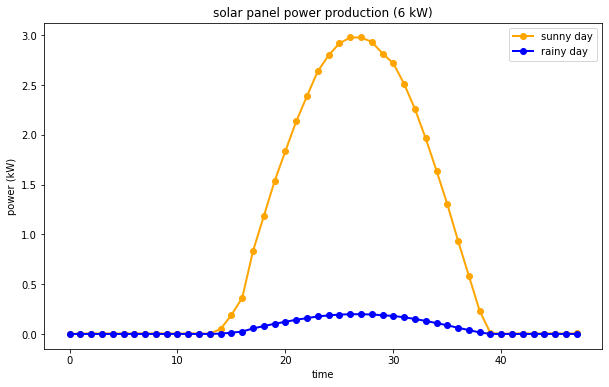

In [3]:
s = pd.read_csv('data/panel_power.csv', delimiter=',', usecols=[1,2,3,4])
display(s.head(4))
plt.figure(figsize=(10,6))
plt.xlabel('time')
plt.ylabel('power (kW)')
plt.title('solar panel power production (6 kW)')
plt.plot(s.time*2, s.sunny, '-o', c='orange', lw=2, label='sunny day')
plt.plot(s.time*2, s.rainy, '-o', c='blue', lw=2, label='rainy day')
plt.legend();

#### Import nodes load curves

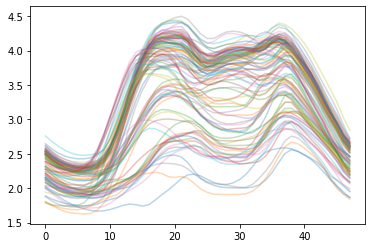

In [4]:
# import load profiles
load_curve_tot = np.load('data/load_agg_pred.npy')

# generate load profiles
def make_load_profiles(n_nodes,T):
    l = np.ndarray(shape=(0, T))
    for i in range(n_nodes):
        l = np.append(l, [load_curve_tot[i*T:(i+1)*T]], axis=0)
    return l*2
    
# plot
l = make_load_profiles(n_nodes=100,T=48)
for i in range(l.shape[0]):
    plt.plot(l[i],alpha=0.3)

### Functions

In [5]:
# Customer's utility function: for optimizing wrt b_pm
def utility_func(b_pm, p, l, s):
    """
    b_pm: charging profile (1x2T)
    p: price vector (1xT)
    b_m: discharging profile (1xT)
    l: load profile (1xT)
    c: running cost of storage
    s: power supply from energy generators 
    
    """
    return np.sum(p * (b_pm[:T] - alpha * b_pm[T:] + l - s))

# make utility func for all nodes
n_active=30
def make_utility(b_pm,p,l,s):
        return np.array( [utility_func(b_pm[node],p,l[node],s) for node in range(n_active) ] )

def constr_matrix_b(alpha):
    """
    alpha: efficiency
    """
    # storage efficiency
    mat1 = np.zeros(shape=(1, 2*T), dtype='float')
    for j in range(T):
        #mat1[0, j] = -alpha
        mat1[0, j] = -1
        mat1[0, j+T] = 1

    # within charging and discharging capacity
    mat2 = np.hstack([np.identity(T, dtype='float'), np.zeros(shape=(T, T), dtype='float')])
    mat3 = np.hstack([np.zeros(shape=(T, T), dtype='float'), np.identity(T, dtype='float')])

    # energy that can be stored or used at a time slot
    mat4 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        #mat4[i, :i] = -alpha
        #mat4[i, T:T+i] = alpha
        mat4[i, :i] = -1
        mat4[i, T:T+i] = 1
    for i in range(T):
        mat4[i, T+i] = 1

    mat5 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat5[i, :i] = 1
        mat5[i, T:T+i] = -1
    for i in range(T):
        mat5[i, i] = 1    

    return np.vstack([mat1, mat2, mat3, mat4, mat5])

def constr_vectors_b(b_sup, b_inf, alpha, e0, e, l):
    """
    n: customer's index
    """
    # left
    leftv1 = np.zeros(1)          # bilateral
    leftv2 = np.zeros(T)          # bilateral
    leftv3 = np.zeros(T)          # bilateral
    leftv4 = -np.ones(T)*np.inf   # unilateral
    leftv5 = -np.ones(T)*np.inf   # unilateral
    leftv_constr = np.concatenate([leftv1, leftv2, leftv3, leftv4, leftv5])

    # right
    rightv_constr = np.concatenate([[0], [b_sup] * T, [b_inf] * T, [e0] * T, [e - e0] * T])
    return leftv_constr, rightv_constr

def optimize_b(func, p, l, s, params, x0):
    
    n_nodes,n_active,n_aware,T,n_days,beta,b_inf,b_sup,alpha,e,e0,p_sun = params
    
    mat_constr = constr_matrix_b(alpha)
    leftv_constr, rightv_constr = constr_vectors_b(b_sup, b_inf, alpha, e0, e, l)
    linear_constraint = LinearConstraint(mat_constr, leftv_constr, rightv_constr)
    bounds = Bounds([0] * 2 * T, [max(b_sup, b_inf)] * 2 * T)
    b_opt = minimize(func, x0, args=(p, l, s), method='trust-constr',
        constraints=linear_constraint,
        bounds=bounds,
        options={'verbose' : 0})
    return b_opt.x

### Parameters

In [8]:
n_nodes  = 100  # total number of consumers
n_active = 30   # consumers with storage and renewable energy
n_aware  = 15   # number of nodes aware of the future meteo
T        = 48   # number of time slots in a day(1 slot = 0.5 hours)
n_days = 30    # number of days to simulate 
beta  = 0.05    # storage profile learning rate
b_inf = 0.2     # maximum discharge in a time slot (kWh)
b_sup = 0.2     # maximum charge in a time slot(kWh)
alpha = 0.8     # efficiency
e     = 5.      # storage capacity
e0    = 0       # initial/final storage level
p_sun = 0.7     # probability of having a sunny day

params = n_nodes,n_active,n_aware,T,n_days,beta,b_inf,b_sup,alpha,e,e0,p_sun

## Active nodes

In [9]:
# Intialization of simulation variables
def init_simulation_var(\
        n_days,
        init_b_pm_ave = {"sunny":np.zeros(shape=[n_active,2*T]),"rainy":np.zeros(shape=[n_active,2*T])},
        init_p = None
        ):
    
    # allocate history vectors
    m_history     = np.random.choice(["sunny","rainy"], size=n_days, p=[p_sun,1-p_sun]) # meteo hystory (a priori)
    b_pm_history  = np.ndarray(shape=(n_days, n_active, T*2))                           # charging profile history
    p_history     = np.ndarray(shape=(n_days, T))                                       # price profile history
    u_history     = np.ndarray(shape=(n_days, n_active))                                # real utility function history
    
    # initialize state variables
    l    = make_load_profiles(n_nodes,T)              # day 0 load profiles
    m    = m_history[0]                               # day 0 meteo
    b_pm = init_b_pm_ave[m]                           # day 0 charging profile (prior)
    p    = make_market_price(b_pm,l,s[m],alpha,T)     # day 0 market price (real)
    u    = make_utility(b_pm,p,l,s[m])                # day 0 utility value (real)
    
    # initialize average state variables (assumed past of simulation)
    b_pm_ave = init_b_pm_ave                                                                                                # average b_pm of past days (modelled)
    b_pm_ave["sunny"][n_aware:] = p_sun*init_b_pm_ave["sunny"][n_aware:] + (1-p_sun)*init_b_pm_ave["rainy"][n_aware:]       # remove meteo information                                                           # average b_pm of past days (imported)
    b_pm_ave["rainy"][n_aware:] = b_pm_ave["sunny"][n_aware:]
    
    if init_p is not None:
        p_ave = init_p
    else: # tre different expected values dependin on the state of knowledge
        p_ave = {}
        p_ave["sunny"] = make_market_price(b_pm_ave["sunny"],l,s["sunny"],alpha,T)
        p_ave["rainy"] = make_market_price(b_pm_ave["rainy"],l,s["rainy"],alpha,T) 
        p_ave["unaware"] = p_sun*p_ave["sunny"] + (1-p_sun)*p_ave["rainy"] 

    
    # pack 
    history = m_history, b_pm_history, p_history, u_history
    state   = l,m,b_pm,p,u
    ave     = b_pm_ave, p_ave
    
    return history, state, ave

### Simulation

In [10]:
history, state, ave = init_simulation_var(n_days)

# unpack
m_history, b_pm_history, p_history, u_history = history
l, m, b_pm, p, u                           = state   # init
b_pm_ave, p_ave,                           = ave

for d in range(1):
    t_start = time.time()
    
    ### EVOLVE STEP
    # set meteo to today's value
    m = m_history[d]
    
    # expected prices for the day (explicit vector in ordet to give easily to parallelization function)
    p_exp = np.array([ (p_ave[m] if i<n_aware else p_ave["unaware"])  for i in range(n_active) ])
    
    # find best response profiles for b_pm
    x0 = b_pm_ave[m] # initial conditions of optimization routine
    with Parallel(n_jobs=n_active) as parallel:
        b_pm_best = np.array( parallel([ delayed(optimize_b)(utility_func, p_exp[i], l[i], s[m], params, x0[i]) for i in range(n_active) ]) )
    
    # compute real (actually played) b_pm 
    beta_aware = beta/p_sun if m=="sunny" else beta/(1-p_sun) # reweights the learning rates in order to adjust for scarsity of data
    b_pm = np.ndarray(shape=(n_active, 2*T))
    b_pm[:n_aware ] = (1-beta_aware)*b_pm_ave[ m     ][:n_aware ] + beta_aware*b_pm_best[:n_aware ] # mixes best resp with average over day with same meteo
    b_pm[ n_aware:] = (1-beta      )*b_pm_ave["sunny"][ n_aware:] + beta      *b_pm_best[ n_aware:] # mixes best resp with average independently of meteo
    # (note) for the unaware updating "sunny" od "rainy" is the same since the two are wqual and are kept so in the "update" phase
    
    # compute actual market prices for the day
    p = make_market_price(b_pm,l,s[m],alpha)
        
    # compute actual utility for the day
    u = make_utility(b_pm,p,l,s[m])
    
    ### UPDATE HISTORY
    b_pm_history[d] = b_pm
    p_history[d]    = p
    u_history[d]    = u
    
    ### UPDATE (conditioned) AVERAGES
    b_pm_ave["sunny"][ n_aware:] = b_pm_history[d][ n_aware:]             # same as b_real (since b real is the average of the best responses)
    b_pm_ave["rainy"][ n_aware:] = b_pm_history[d][ n_aware:]             # which for the unaware is updated independently of the m of today
    b_pm_ave[ m     ][:n_aware ] = b_pm_history[d][:n_aware ]             # updates only b_pm_ave of the current meteo
    p_ave[    m    ] = (1-beta_aware)*p_ave[m]         + beta_aware*p     # updates only p        of the current meteo
    p_ave["unaware"] = (1-beta      )*p_ave["unaware"] + beta      *p     # updates only p independently of meteo
    
    
    # timer
    t_stop = time.time()
    time_elapsed = round((t_stop - t_start)/60, 2)
    print('completed day {d}/{n_days} in {mins} min'.format(d=d+1, n_days=n_days, mins=time_elapsed))
    
b_history = b_pm_history[:,:,:T]-b_pm_history[:,:,T:]

completed day 1/30 in 0.17 min


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in subtract


In [ ]:
time.time()-t_start

In [ ]:
    for n in range(n_smart):
        b_opt = np.append(b_opt, [b_opt_list[n]], axis=0)

    # update b
    b_pm = b_pm + beta * (b_opt - b_pm)
    x0 = b_opt

    # update e0
    e0 = e0 + b_pm[:, :T].sum() - b_pm[:, T:].sum()

    b_history = np.append(b_history, [b_pm[:, :T] - b_pm[:, T:]], axis=0)
    p = market_price(l_day.sum(axis=0) - alpha * b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0) - n_smart * s[weather])
    p_history = np.append(p_history, [p], axis=0)
    u_history = np.append(u_history, [[u(b_pm[n, :], p, l_day[n, :], s[weather]) for n in range(n_smart)]], axis=0)
    t_stop = time.time()
    time_elapsed = round((t_stop - t_start)/60, 2)
    print('completed day {d}/{n_days} in {mins} min'.format(d=d+1, n_days=n_days, mins=time_elapsed))

In [ ]:
plt.figure(figsize=(10,6))
plt.title('average daily cost for a customer with solar panels', size=15)
plt.xlabel('trading day', size=15)
plt.ylabel('cost (Euro)', size=15)
plt.plot(u_history.mean(axis=1), '-o', c='black', alpha=0.7);

In [ ]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6))
X = np.arange(1, T+1, 1)
Y = np.arange(1, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, b_history.mean(axis=1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=12)
ax.set_xlabel('Daily', size=12)
ax.set_zlabel('Power (kW)', size=12)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
ax.set_title('Average storage profile', size=12, fontweight='bold');

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Daily', size=12)
plt.ylabel('Storage profile (kW)', size=12)
plt.title('Optimal storage profile', size=12, fontweight='bold')
plt.hlines(xmin=0, xmax=48, y=0., ls='dashed', color='black', alpha=0.4)
#plt.plot(b_history.mean(axis=1)[-1], '-o', c='black', alpha=0.8);
for i in range(n_smart):
    plt.plot(b_history[-1, i, :])
plt.grid(alpha=0.5)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
t = np.arange(T)

cost_smart = p_history[-1, :] * (b_history[-1, :] + load_curve - s[weather])
ax[0].set_title('cost of energy for a smart user')
ax[0].set_xlabel('daily hour')
ax[0].set_ylabel('cost (Euro)')
ax[0].plot(t, cost_smart, '-o', c='red', alpha=0.7)
ax[0].grid(alpha=0.5)

cost_normal = p_history[-1, :] * load_curve
ax[1].set_title('cost of energy for a normal user')
ax[1].set_xlabel('daily hour')
ax[1].set_ylabel('cost (Euro)')
ax[1].plot(t, cost_normal, '-o', c='blue', alpha=0.7)
ax[1].grid(alpha=0.5)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6))
X = np.arange(1, T+1, 1)
Y = np.arange(0, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, p_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=12)
ax.set_xlabel('Daily', size=12)
ax.set_zlabel('Price (€/kWh)', size=12)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
ax.set_title('Changing market prices', size=12, fontweight='bold');

In [ ]:
e0 = np.cumsum(b_history.sum(axis=1))
plt.plot(np.arange(1,n_days+1,1), e0, '-o', c='black', alpha=0.5)
plt.title('Storage profile', size=15)
plt.ylabel(r'$e_0$ (kWh)', size=15)
plt.xlabel('trading day', size=15);
plt.grid(alpha=0.5)

In [ ]:
np.save('Results/b_history-{w}-{dd}d.npy'.format(w=weather, dd=n_days), b_history)
np.save('Results/p_history-{w}-{dd}d.npy'.format(w=weather, dd=n_days), p_history)
np.save('Results/u_history-{w}-{dd}d.npy'.format(w=weather, dd=n_days), u_history)